# Imports

In [1]:
import warnings
from collections import defaultdict

import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.signal import resample
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

from khan_helpers import Experiment
from khan_helpers.constants import (
    BOS_LECTURE_COLOR,
    BOS_QUESTION_COLOR,
    FIG_DIR,
    FORCES_LECTURE_COLOR,
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR,
    LECTURE_WSIZE,
    RAW_DIR, 
    TRAJS_DIR
)
from khan_helpers.functions import (
    _ts_to_sec,
    disable_logging,
    format_stats,
    interp_lecture,
    parse_windows,
    set_figure_style
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some plotting functions

In [2]:
def plot_3d_trajectories(
    lec1, 
    lec2, 
    questions, 
    resample_len=None, 
    smoothing_len=None,
    ax=None,
    **kwargs
):
    if resample_len is None:
        lec1_resampled, lec2_resampled = lec1, lec2
    else:
        lec1_resampled = resample(lec1, resample_len, axis=0)
        lec2_resampled = resample(lec2, resample_len, axis=0)
    
    if smoothing_len is None:
        lec1_smoothed, lec2_smoothed = lec1_resampled, lec2_resampled
    else:
        lec1_smoothed = (pd.DataFrame(lec1_resampled)
                         .rolling(smoothing_len)
                         .mean()
                         .loc[smoothing_len:, :]
                         .to_numpy())
        lec2_smoothed = (pd.DataFrame(lec2_resampled)
                         .rolling(smoothing_len)
                         .mean()
                         .loc[smoothing_len:, :]
                         .to_numpy())
    lec1_qs = questions[:15]
    lec2_qs = questions[15:30]
    gen_qs = questions[30:]
        
    geo = hyp.plot([lec1_smoothed, lec2_smoothed, lec1_qs, lec2_qs, gen_qs], 
                   fmt=['-', '-', 'o', 'o', 'o'], 
                   color=[FORCES_LECTURE_COLOR, 
                          BOS_LECTURE_COLOR, 
                          FORCES_QUESTION_COLOR, 
                          BOS_QUESTION_COLOR, 
                          GENERAL_QUESTION_COLOR], 
                   reduce={'model': 'IncrementalPCA', 'params': {'whiten': True}}, 
                   ax=ax,
                   **kwargs)
    return geo

In [3]:
def plot_correlation_timeseries(
    lecture, 
    questions, 
    ax=None, 
    legend=False,
    labelstart=1,
    **kwargs
):    
    if ax is None:
        ax = plt.gca()
    
    color = kwargs.pop('c', kwargs.pop('color', None))
    qcorrs = 1 - cdist(lecture, questions, 'correlation')
    ax.plot(qcorrs, color=color, **kwargs)
    
    ax.set_xlim(0, len(lecture))
    ticks = list(range(0, len(lecture) + 1, 60))
    ax.set_xticks(ticks, (f'{t // 60}:00' for t in ticks))
    ax.set_xlabel('Lecture time')
    
    ax.grid(visible=False)
    
    if legend:
        ax.legend(labels=[f'Q {i}' for i in range(labelstart, labelstart+15)], 
                  fontsize=12.5, 
                  loc=3, 
                  ncol=8, 
                  mode='expand',
                  bbox_to_anchor=(-0.01, -0.35, 1.02, 1))
    return ax

In [4]:
def plot_variance_corrmat(
    lec1, 
    lec2, 
    questions, 
    ticklabels=None,
    labelsize='medium',
    ax=None, 
    cbar_ax=None,
    **kwargs
):
    # set argument defaults
    if ax is None:
        ax = plt.gca()
        
    if ticklabels is None:
        ticklabels = [
            'Four\nFundamental\nForces\nlecture', 
            'Four\nFundamental\nForces\nquestions', 
            'Birth of\nStars\nlecture', 
            'Birth of\nStars\nquestions', 
            'General\nphysics\nknowledge\nquestions'
        ]
    kwargs.setdefault('xticklabels', ticklabels[:-1] + [''])
    kwargs.setdefault('yticklabels', [''] + ticklabels[1:])
    
    if labelsize is None:
        labelsize = 'medium'
    
    kwargs.setdefault('square', True)
    kwargs.setdefault('fmt', '')
    
    annot_kws = {
        'style': 'italic',    
        'fontweight': 'semibold',
        'linespacing': 1.5
    }
    if (user_annot_kws := kwargs.pop('annot_kws', None)) is not None:
        annot_kws.update(user_annot_kws)
    
    cbar_kws={'label': 'Correlation'}
    if (user_cbar_kws := kwargs.pop('cbar_kws', None)) is not None:
        cbar_kws.update(user_cbar_kws)
    
    # compute feature variances & pairwise correlations
    feature_vars = [lec1.var(axis=0),                # Lecture 1
                    questions[:15].var(axis=0),      # Lecture 1 questions
                    lec2.var(axis=0),                # Lecture 2
                    questions[15:30].var(axis=0),    # Lecture 2 questions
                    questions[30:].var(axis=0)]      # General knowledge questions
    
    # pairwise correlations for coloring heatmap (lower triangle only)
    vars_corrmat = np.full((len(feature_vars), len(feature_vars)), np.nan)
    # formatted r- and p-values for annotating heatmap cells (triu only)
    annot_matrix = np.empty_like(vars_corrmat, dtype='<U64')
    for i, x_vars in enumerate(feature_vars):
        for j, y_vars in enumerate(feature_vars):
            if i == j:
                break
                
            r, p = pearsonr(x_vars, y_vars)
            vars_corrmat[i, j] = r
            annot_matrix[i, j] = format_stats(r, p, stat_name='r')
        
    sns.heatmap(vars_corrmat, 
                annot=pd.DataFrame(annot_matrix), 
                annot_kws=annot_kws,
                ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws=cbar_kws,
                **kwargs)
    
    ax.tick_params(axis='x', rotation=0, length=0, pad=10, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, length=0, pad=60, labelsize=labelsize)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), ha='center')
    
    if cbar_ax is not None:
        cbar_ax.tick_params('y', length=0, pad=40)
        cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), ha='right')
        cbar_ax.set_ylabel(cbar_ax.get_ylabel(), fontsize='large', labelpad=10)
    
    return ax

# Load LDA embeddings and raw data to create BERT embeddings

In [5]:
exp = Experiment()

forces_traj_lda = exp.forces_traj
bos_traj_lda = exp.bos_traj
questions_vecs_lda = exp.question_vectors

forces_transcript = exp.forces_transcript
bos_transcript = exp.bos_transcript
questions_text = exp.questions['question'].tolist()

# Parse lecture transcripts into overlapping sliding windows

In [6]:
# make the same minor corrections to the transcripts as for the LDA 
# version, but don't do any further preprocessing since GPT-J is 
# context-sensitive
transcription_tweaks = {
    'cork': 'quark',
    'sub atomic': 'subatomic',
    'sub nucleic': 'subnucleic',
    'electro magnetic': 'electromagnetic',
    'electro static': 'electrostatic',
    'Ullom': 'coulomb',
    'cool': 'coulomb',
    'Hugh': 'huge',
    'hydrogen too': 'hydrogen two',
    ' eat': ' heat',
    ' cure ': ' core ',
    '10 ': 'ten ',
    '38 ': 'thirtyeight ',
    '38th ': 'thirtyeight ',
    '36 ': 'thirtysix',
    '25 ': 'twentyfive',
    '25th ': 'twentyfive'
}

for old, new in transcription_tweaks.items():
    forces_transcript = forces_transcript.replace(old, new)
    bos_transcript = bos_transcript.replace(old, new)
    
forces_windows_unprocessed, forces_timestamps = parse_windows(forces_transcript, 
                                                              LECTURE_WSIZE)
bos_windows_unprocessed, bos_timestamps = parse_windows(bos_transcript, 
                                                        LECTURE_WSIZE)
# remove trailing timestamp
forces_timestamps = forces_timestamps[:-1]
bos_timestamps = bos_timestamps[:-1]

# Save lecture and question text to create BERT embeddings

Done in this Colab notebook: https://colab.research.google.com/drive/1S4KQSfQvqgR2Ft9asck9VAJLM48FTbfu

In [7]:
# np.save(RAW_DIR.joinpath('forces_windows_unprocessed'), forces_windows_unprocessed)
# np.save(RAW_DIR.joinpath('bos_windows_unprocessed'), bos_windows_unprocessed)

# Load in BERT embeddings

In [8]:
forces_traj_bert_windows = np.load(TRAJS_DIR.joinpath('forces_traj_BERT.npy'))
bos_traj_bert_windows = np.load(TRAJS_DIR.joinpath('bos_traj_BERT.npy'))
questions_vecs_bert = np.load(TRAJS_DIR.joinpath('all_questions_BERT.npy'))

In [9]:
# interpolate lecture trajectories to 1 topic vector per second
forces_traj_bert = interp_lecture(forces_traj_bert_windows, forces_timestamps)
bos_traj_bert = interp_lecture(bos_traj_bert_windows, bos_timestamps)

# Create analogous plots for both sets of embeddings

In [10]:
# save figure components to subdirectory 
MODS_FIG_DIR = FIG_DIR.joinpath('model-comparison-components')
MODS_FIG_DIR.mkdir(exist_ok=True)

# set of shared parameters for figures
shared_params = {
    'plot_3d_trajectories': {
        'resample_len': 200,
        'smoothing_len': 24,
        'azim': 73,
        'elev': 7,
        'size': [7, 7]
    },
    'plot_correlation_timeseries': {
        'figsize': (10, 7),
        'ylim': (-0.24, 1.05),
        'title_kwargs': {
            'y': 1.05,
            'fontsize': 'medium',
            'fontweight': 'semibold'
        }
    },
    'plot_variance_corrmat': {
        'figsize': (15, 11),
        'cbar_rect': (0.6, 0.29, 0.02, 0.44),
        'corrmat_kwargs': {
            'vmin': -0.65,
            'vmax': 1
        }
    }
}

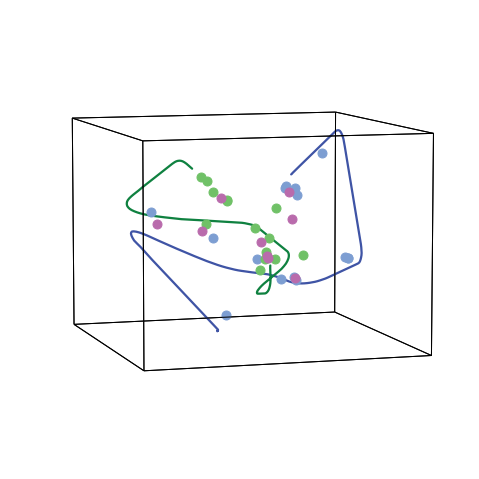

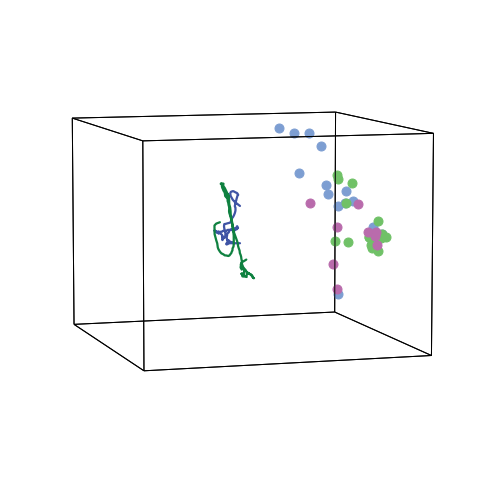

In [11]:
with sns.plotting_context('talk'):
    plot_3d_trajectories(forces_traj_lda, 
                         bos_traj_lda, 
                         questions_vecs_lda,
#                          save_path=MODS_FIG_DIR.joinpath('3d-trajectories-LDA.pdf'),
                         **shared_params['plot_3d_trajectories'])
    plt.show()
    plot_3d_trajectories(forces_traj_bert, 
                         bos_traj_bert, 
                         questions_vecs_bert,
#                          save_path=MODS_FIG_DIR.joinpath('3d-trajectories-BERT.pdf'),
                         **shared_params['plot_3d_trajectories'])

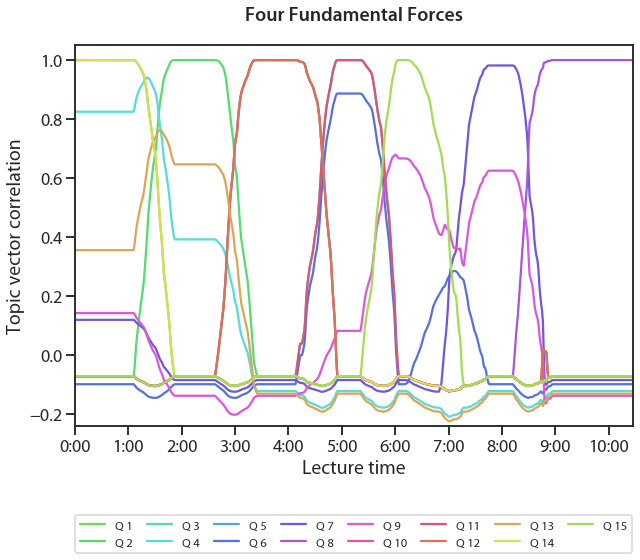

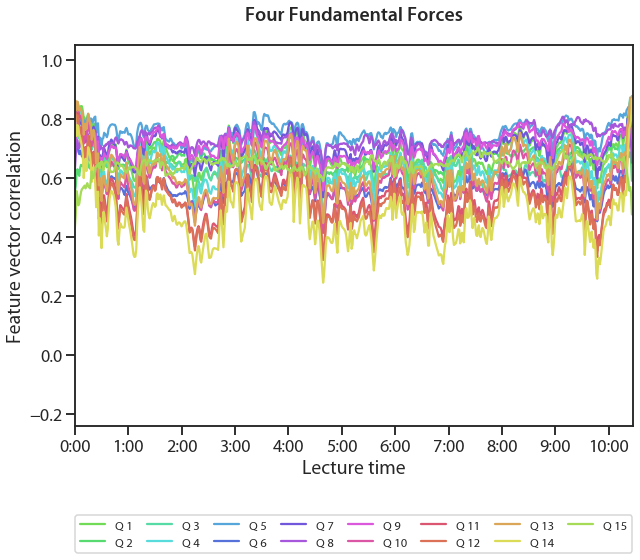

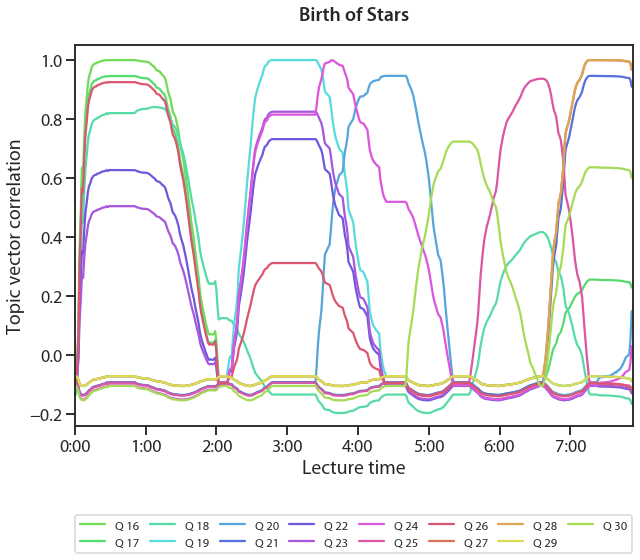

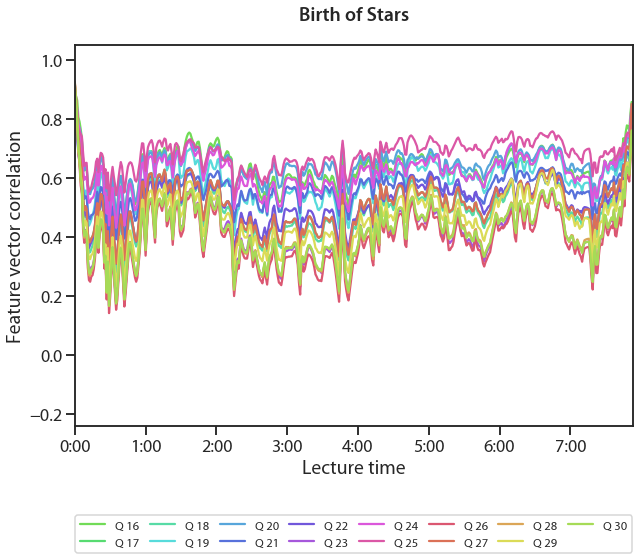

In [12]:
qcorr_params = shared_params['plot_correlation_timeseries']

with (
    sns.plotting_context('talk', font_scale=1.1),
    sns.axes_style('ticks'), 
    sns.color_palette(sns.hls_palette(15, h=.3))
):
    set_figure_style()
    fig, ax = plt.subplots(figsize=qcorr_params['figsize'])
    plot_correlation_timeseries(forces_traj_lda, 
                                questions_vecs_lda[:15], 
                                ax=ax, 
                                legend=True, 
                                labelstart=1)
    ax.set_ylim(*qcorr_params['ylim'])
    ax.set_ylabel('Topic vector correlation')
    ax.set_title('Four Fundamental Forces', **qcorr_params['title_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('forces-qcorrs-LDA.pdf'), bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    
    fig, ax = plt.subplots(figsize=qcorr_params['figsize'])
    plot_correlation_timeseries(forces_traj_bert, 
                                questions_vecs_bert[:15], 
                                ax=ax, 
                                legend=True, 
                                labelstart=1)
    ax.set_ylim(*qcorr_params['ylim'])
    ax.set_ylabel('Feature vector correlation')
    ax.set_title('Four Fundamental Forces', **qcorr_params['title_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('forces-qcorrs-BERT.pdf'), bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    
    fig, ax = plt.subplots(figsize=qcorr_params['figsize'])
    plot_correlation_timeseries(bos_traj_lda, 
                                questions_vecs_lda[15:30], 
                                ax=ax, 
                                legend=True, 
                                labelstart=16)
    ax.set_ylim(*qcorr_params['ylim'])
    ax.set_ylabel('Topic vector correlation')
    ax.set_title('Birth of Stars', **qcorr_params['title_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('bos-qcorrs-LDA.pdf'), bbox_inches='tight')
    plt.show()
    
    # ==================================================================
    
    fig, ax = plt.subplots(figsize=qcorr_params['figsize'])
    plot_correlation_timeseries(bos_traj_bert, 
                                questions_vecs_bert[15:30], 
                                ax=ax, 
                                legend=True, 
                                labelstart=16)
    ax.set_ylim(*qcorr_params['ylim'])
    ax.set_ylabel('Feature vector correlation')
    ax.set_title('Birth of Stars', **qcorr_params['title_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('bos-qcorrs-BERT.pdf'), bbox_inches='tight')
    plt.show()

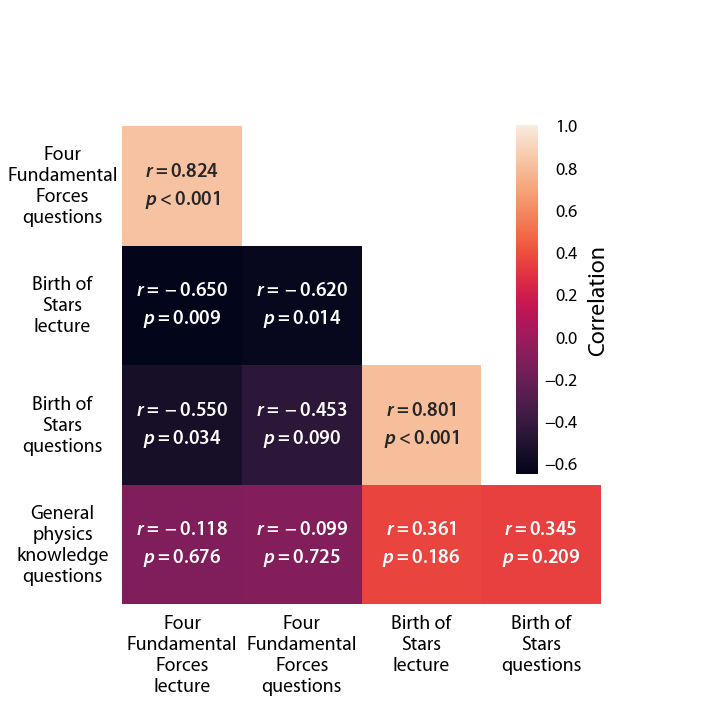

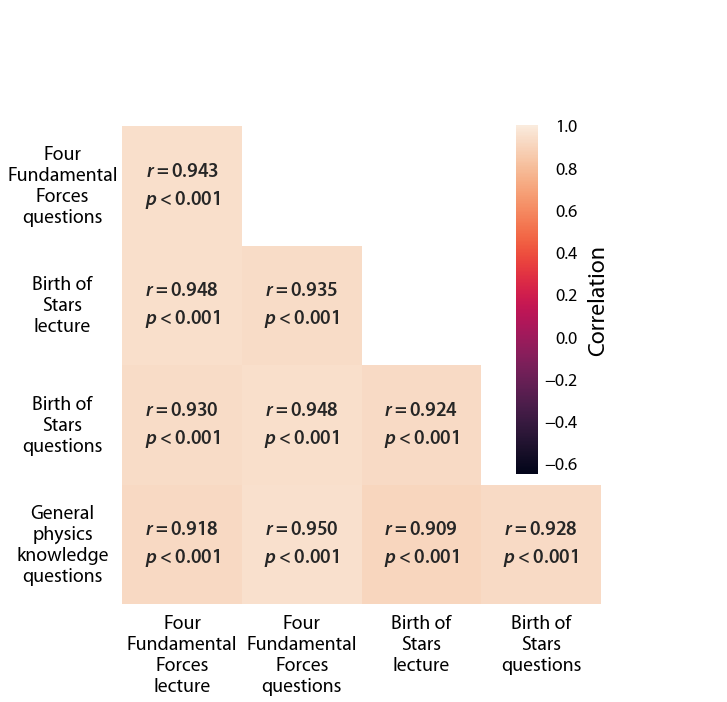

In [13]:
corrmat_params = shared_params['plot_variance_corrmat']

with (
    sns.plotting_context('talk', font_scale=1.1),
    warnings.catch_warnings(),
    disable_logging('matplotlib.font_manager', 'ERROR'), 
    plt.rc_context({
        'mathtext.fontset': 'custom', 
        'mathtext.it': 'sans:semibold:italic',
        'mathtext.bf': 'sans:semibold'
    })
):
    warnings.filterwarnings(
        'ignore', 
        message=('FixedFormatter should only be used together with FixedLocator'), 
        category=UserWarning
    )
    set_figure_style()
    
    fig, ax = plt.subplots(figsize=corrmat_params['figsize'])
    cbar_ax = fig.add_axes(corrmat_params['cbar_rect'])
    plot_variance_corrmat(forces_traj_lda, 
                          bos_traj_lda, 
                          questions_vecs_lda, 
                          ax=ax,
                          cbar_ax=cbar_ax,
                          **corrmat_params['corrmat_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('active-topics-corrmat-LDA.pdf'), 
#                 bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=corrmat_params['figsize'])
    cbar_ax = fig.add_axes(corrmat_params['cbar_rect'])
    plot_variance_corrmat(forces_traj_bert, 
                          bos_traj_bert, 
                          questions_vecs_bert,
                          ax=ax,
                          cbar_ax=cbar_ax,
                          **corrmat_params['corrmat_kwargs'])
#     plt.savefig(MODS_FIG_DIR.joinpath('active-topics-corrmat-BERT.pdf'), 
#                 bbox_inches='tight')
    plt.show()